#### Importing required libraries

In [68]:
Name: Md.Mehedy Hasan Siam & Email: mehedisiam10@gmail.com


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

The images in data should should be resized to mentioned width and height as now we are proceeding to use another model. 

In [69]:
SIZE = 224

#### Training Dataset

In [70]:
# loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../input/signature-verification-dataset/sign_data/train/',
    image_size=(224, 224)
)

Found 1649 files belonging to 128 classes.


#### Testing Dataset

In [71]:
# loading training data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../input/signature-verification-dataset/sign_data/test/',
    seed=42,
    image_size=(224, 224)
)

Found 500 files belonging to 42 classes.


#### Images
We have following images in training data.

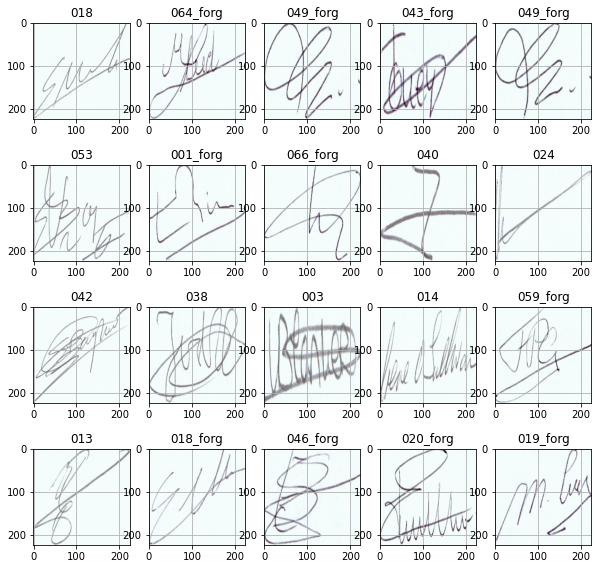

In [72]:
class_names = training_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # print(images[i])
        plt.title(class_names[labels[i]])
        plt.grid(True)

These are the images in testing data.

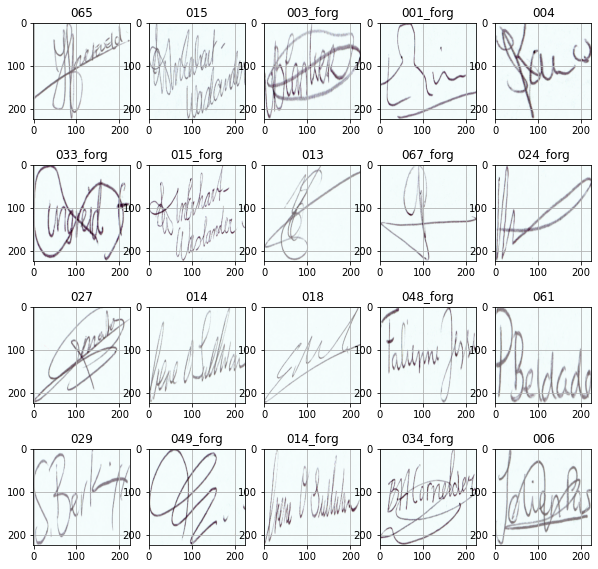

In [73]:
class_names = training_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # print(images[i])
        plt.title(class_names[labels[i]])
        plt.grid(True)

#### Savind image data in numpy array

In [74]:
import cv2
import os
import glob

train_data = []
train_labels = []

for per in os.listdir('../input/signature-verification-dataset/sign_data/train/'):
    for data in glob.glob('../input/signature-verification-dataset/sign_data/train/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        train_data.append([img])
        if per[-1]=='g':
            train_labels.append(np.array(1))
        else:
            train_labels.append(np.array(0))
train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

#Test Data
test_data = []
test_labels = []
for per in os.listdir('../input/signature-verification-dataset/sign_data/test/'):
    for data in glob.glob('../input/signature-verification-dataset/sign_data/test/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        test_data.append([img])
        if per[-1]=='g':
            test_labels.append(np.array(1))
        else:
            test_labels.append(np.array(0))
test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)

For use of categorical entropy loss we need to configure data. 

In [75]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)

#### Shapes of numpy array made above.

In [76]:
train_data.shape

(1649, 1, 224, 224, 3)

In [77]:
train_data = train_data.reshape(-1, SIZE,SIZE, 3)
test_data = test_data.reshape(-1, SIZE,SIZE, 3)

In [78]:
train_data.shape

(1649, 224, 224, 3)

In [79]:
train_labels.shape

(1649, 2)

#### Shuffling

In [80]:
from sklearn.utils import shuffle
train_data,train_labels = shuffle(train_data,train_labels)
test_data,test_labels = shuffle(test_data,test_labels)

#### Importing base model  (VGG-16)

In [81]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import Adam

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Our model
Here we are freezing first 5 layers og VGG-16 and adding top layers.

In [82]:
i=0
while i != 5:
    base_model.layers[i].trainable = False
    i+=1
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(2, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

#### Training our model

In [83]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]

progess = model.fit(train_data,train_labels, batch_size=30,epochs=100, callbacks=early_stop,validation_split=.3)

Epoch 1/100
39/39 [==============================] - 7s 177ms/step - loss: 0.6905 - accuracy: 0.6075 - val_loss: 0.5346 - val_accuracy: 0.7232
Epoch 2/100
39/39 [==============================] - 6s 163ms/step - loss: 0.3807 - accuracy: 0.8432 - val_loss: 0.2396 - val_accuracy: 0.9394
Epoch 3/100
39/39 [==============================] - 6s 163ms/step - loss: 0.1658 - accuracy: 0.9376 - val_loss: 0.1039 - val_accuracy: 0.9636
Epoch 4/100
39/39 [==============================] - 6s 164ms/step - loss: 0.0922 - accuracy: 0.9679 - val_loss: 0.0862 - val_accuracy: 0.9576
Epoch 5/100
39/39 [==============================] - 6s 163ms/step - loss: 0.0848 - accuracy: 0.9705 - val_loss: 0.1830 - val_accuracy: 0.9253
Epoch 6/100
39/39 [==============================] - 6s 162ms/step - loss: 0.0690 - accuracy: 0.9714 - val_loss: 0.1066 - val_accuracy: 0.9697
Epoch 7/100
39/39 [==============================] - 6s 162ms/step - loss: 0.1310 - accuracy: 0.9541 - val_loss: 0.1236 - val_accuracy: 0.9636

#### Accuracy plot.

<Figure size 432x288 with 0 Axes>

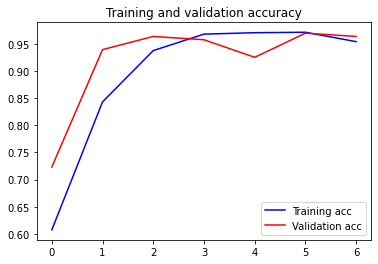

<Figure size 432x288 with 0 Axes>

In [84]:
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

#### Loss plot.

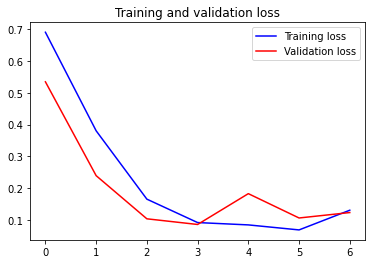

In [85]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

#### Accuracy Score.

In [89]:
pred = model.predict(test_data)

In [87]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(pred,axis=1), test_labels)

0.998